[I 2025-06-22 23:32:06,564] A new study created in memory with name: no-name-6763a56e-89b3-4474-9582-f0f66d889989


Usando dispositivo: cuda
Datos cargados: (3680, 20)
Columnas: ['id', 'id_bar', 'anio', 'semana', 'ESTRATO', 'area_barrio', 'dengue', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']
Tamaño conjunto de entrenamiento: (3150, 21)
Tamaño conjunto de validación: (530, 21)
Variables categóricas: ['id_bar', 'ESTRATO']
Variables numéricas: ['id', 'area_barrio', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']
Dimensión características de entrenamiento: (3150, 28)
Dimensión características de validación: (530, 28)
Iniciando optimización de hiperparámetros...


[I 2025-06-22 23:32:11,406] Trial 0 finished with value: 0.10778003185987473 and parameters: {'window_size': 36, 'hidden_size': 47, 'num_layers': 3, 'learning_rate': 0.0009565801858460212, 'batch_size': 64}. Best is trial 0 with value: 0.10778003185987473.
[I 2025-06-22 23:32:18,400] Trial 1 finished with value: 0.5888271182775497 and parameters: {'window_size': 29, 'hidden_size': 117, 'num_layers': 1, 'learning_rate': 0.004832885884478095, 'batch_size': 32}. Best is trial 0 with value: 0.10778003185987473.
[I 2025-06-22 23:32:37,199] Trial 2 finished with value: 0.8187490999698639 and parameters: {'window_size': 47, 'hidden_size': 108, 'num_layers': 1, 'learning_rate': 0.0006808362357354664, 'batch_size': 32}. Best is trial 0 with value: 0.10778003185987473.
[I 2025-06-22 23:32:43,737] Trial 3 finished with value: 1.3119776844978333 and parameters: {'window_size': 11, 'hidden_size': 67, 'num_layers': 1, 'learning_rate': 0.004744607808628636, 'batch_size': 128}. Best is trial 0 with va

Mejores hiperparámetros encontrados:
{'window_size': 38, 'hidden_size': 32, 'num_layers': 3, 'learning_rate': 0.001785096248243352, 'batch_size': 64}
Mejor MSE en validación: 0.0963

Entrenando modelo final con mejores hiperparámetros...
Época [10/100], Loss Train: 0.3484, Loss Val: 0.4430
Época [20/100], Loss Train: 0.2682, Loss Val: 0.3697
Época [30/100], Loss Train: 0.2275, Loss Val: 0.3638
Época [40/100], Loss Train: 0.1721, Loss Val: 0.3591
Época [50/100], Loss Train: 0.1349, Loss Val: 0.4010
Época [60/100], Loss Train: 0.1148, Loss Val: 0.4242
Época [70/100], Loss Train: 0.0836, Loss Val: 0.4375
Época [80/100], Loss Train: 0.0741, Loss Val: 0.4657
Época [90/100], Loss Train: 0.0631, Loss Val: 0.4637
Época [100/100], Loss Train: 0.0650, Loss Val: 0.4482


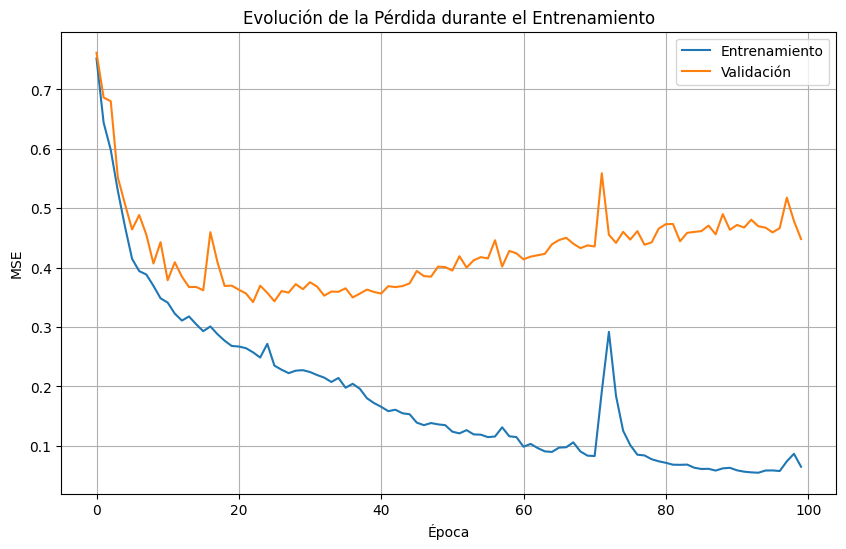

Pronósticos generados hasta la semana 10/52
Pronósticos generados hasta la semana 20/52
Pronósticos generados hasta la semana 30/52
Pronósticos generados hasta la semana 40/52
Pronósticos generados hasta la semana 50/52

Archivo 'pronosticos_2022.csv' creado exitosamente con 520 pronósticos

Primeras 10 filas del archivo de salida:
               id    dengue
0  0.0_2022.0_1.0  4.391927
1  1.0_2022.0_1.0  1.281910
2  2.0_2022.0_1.0  9.233541
3  3.0_2022.0_1.0  3.014481
4  4.0_2022.0_1.0  4.231697
5  5.0_2022.0_1.0  2.177802
6  6.0_2022.0_1.0  1.169095
7  7.0_2022.0_1.0  3.123833
8  8.0_2022.0_1.0  0.123255
9  9.0_2022.0_1.0  0.533856

Estadísticas de pronósticos:
Mínimo: 0.12
Máximo: 19.31
Media: 2.82
Desviación estándar: 3.93


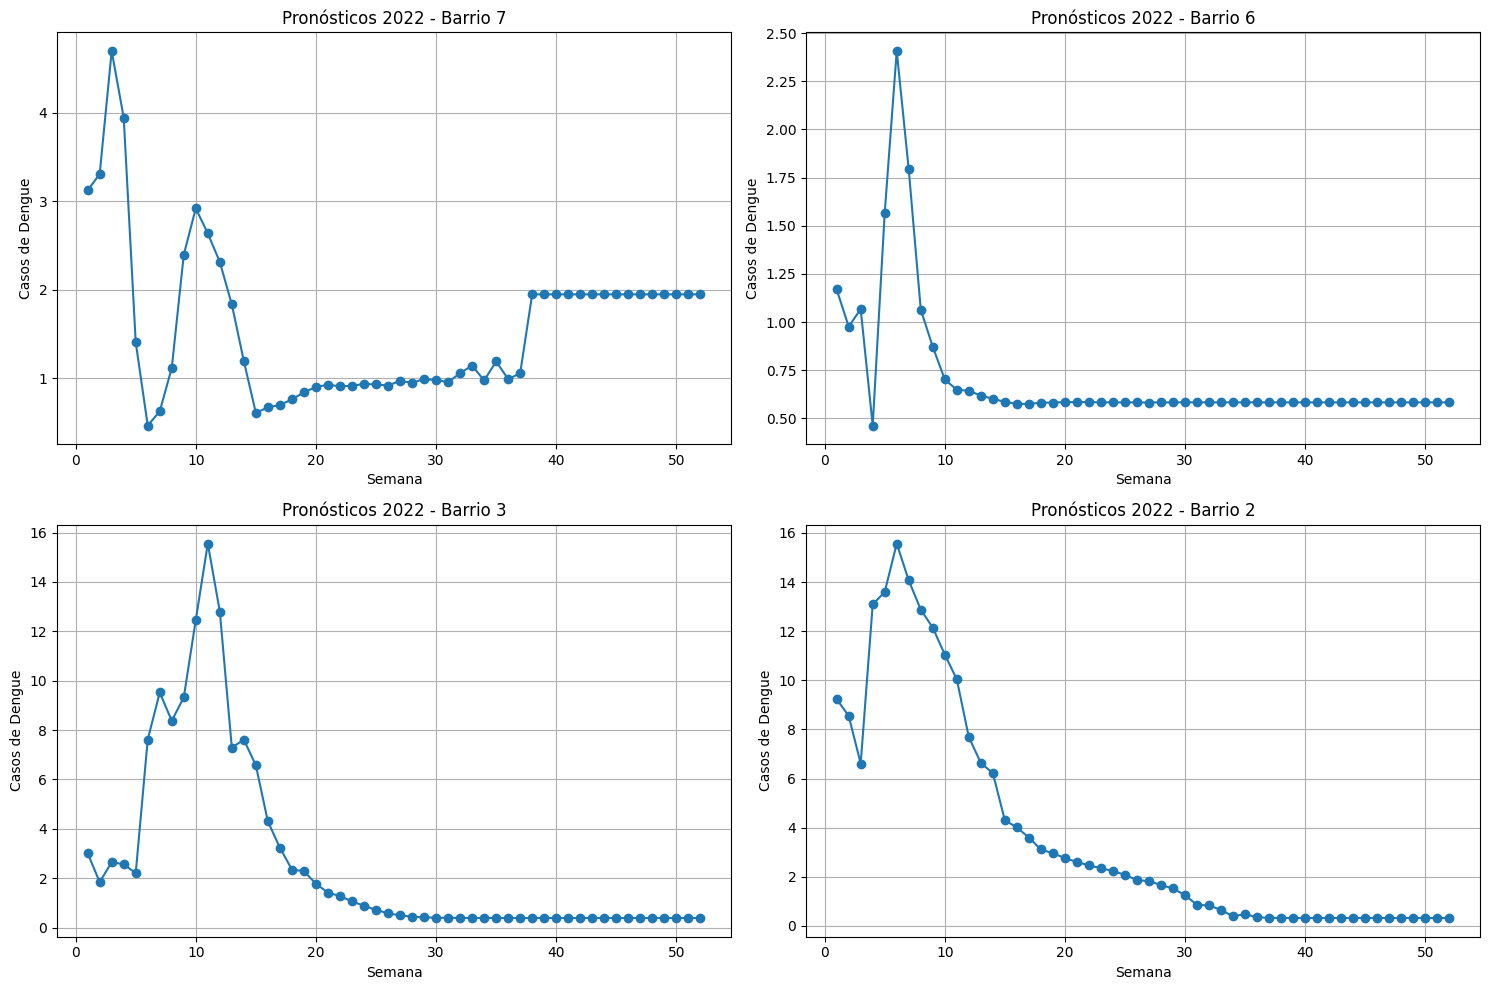


¡Proceso completado exitosamente!


In [ ]:
# Pronóstico de Casos de Dengue usando RNN en PyTorch

## 1. Importación de Librerías

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import optuna
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
from datetime import date
warnings.filterwarnings('ignore')

# Configuración de dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

## 2. Carga y Preparación de Datos

# Cargar datos desde el archivo Parquet
df = pd.read_parquet('../../Datos/df_train.parquet')
print(f"Datos cargados: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")

# Crear columna de fecha/secuencia combinando año y semana
# Manejar correctamente las semanas ISO
def create_date_from_year_week(year, week):
    """Crea una fecha a partir del año y número de semana ISO"""
    # Primer día del año
    jan1 = datetime(year, 1, 1)
    # Encontrar el primer lunes del año
    days_to_monday = (7 - jan1.weekday()) % 7
    first_monday = jan1 + timedelta(days=days_to_monday)
    # Calcular la fecha de la semana específica
    target_date = first_monday + timedelta(weeks=week-1)
    return target_date

df['fecha'] = df.apply(lambda row: create_date_from_year_week(int(row['anio']), int(row['semana'])), axis=1)
df = df.sort_values(['id_bar', 'fecha'])

# División de datos
# Entrenamiento: todas las semanas estrictamente menores al año 2021
# Validación: todas las semanas del año 2021
train_df = df[df['anio'] < 2021].copy()
val_df = df[df['anio'] == 2021].copy()

print(f"Tamaño conjunto de entrenamiento: {train_df.shape}")
print(f"Tamaño conjunto de validación: {val_df.shape}")

## 3. Preprocesamiento de Datos

# Identificar columnas categóricas y numéricas
categorical_cols = ['id_bar', 'ESTRATO']
# Excluir columnas de identificación y la variable objetivo
exclude_cols = ['anio', 'semana', 'fecha', 'dengue'] + categorical_cols
numeric_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Variables categóricas: {categorical_cols}")
print(f"Variables numéricas: {numeric_cols}")

# Crear pipeline de preprocesamiento
# One-Hot Encoding para categóricas
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar el encoder con todos los datos para conocer todas las categorías
ohe.fit(df[categorical_cols])
categorical_feature_names = ohe.get_feature_names_out(categorical_cols)

# Transformar datos categóricos
train_cat_encoded = ohe.transform(train_df[categorical_cols])
val_cat_encoded = ohe.transform(val_df[categorical_cols])

# Escalado de variables numéricas
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Ajustar escaladores solo con datos de entrenamiento
scaler_X.fit(train_df[numeric_cols])
scaler_y.fit(train_df[['dengue']])

# Transformar datos numéricos
train_num_scaled = scaler_X.transform(train_df[numeric_cols])
val_num_scaled = scaler_X.transform(val_df[numeric_cols])

# Escalar variable objetivo
train_y_scaled = scaler_y.transform(train_df[['dengue']])
val_y_scaled = scaler_y.transform(val_df[['dengue']])

# Combinar características categóricas y numéricas
train_X = np.hstack([train_cat_encoded, train_num_scaled])
val_X = np.hstack([val_cat_encoded, val_num_scaled])

# Crear diccionarios para mapear id_bar a índices y viceversa
unique_bars = sorted(df['id_bar'].unique())
bar_to_idx = {bar: idx for idx, bar in enumerate(unique_bars)}
idx_to_bar = {idx: bar for bar, idx in bar_to_idx.items()}

print(f"Dimensión características de entrenamiento: {train_X.shape}")
print(f"Dimensión características de validación: {val_X.shape}")

## 4. Creación de Secuencias (Ventanas Deslizantes)

def create_sequences(X, y, id_bars, window_size):
    """
    Crea secuencias de datos para la RNN procesando cada id_bar independientemente.
    
    Args:
        X: matriz de características (n_samples, n_features)
        y: valores objetivo escalados (n_samples, 1)
        id_bars: array con el id_bar de cada muestra
        window_size: tamaño de la ventana de entrada
    
    Returns:
        X_seq: secuencias de entrada (n_sequences, window_size, n_features)
        y_seq: valores objetivo para cada secuencia (n_sequences,)
        bar_seq: id_bar correspondiente a cada secuencia
    """
    X_seq, y_seq, bar_seq = [], [], []
    
    # Procesar cada barrio independientemente
    for bar in np.unique(id_bars):
        # Filtrar datos del barrio actual
        bar_mask = id_bars == bar
        X_bar = X[bar_mask]
        y_bar = y[bar_mask]
        
        # Crear secuencias para este barrio
        for i in range(len(X_bar) - window_size):
            X_seq.append(X_bar[i:i+window_size])
            y_seq.append(y_bar[i+window_size, 0])  # Predecir siguiente semana
            bar_seq.append(bar)
    
    return np.array(X_seq), np.array(y_seq), np.array(bar_seq)

# Dataset personalizado para PyTorch
class DengueDataset(Dataset):
    def __init__(self, X_seq, y_seq):
        self.X = torch.FloatTensor(X_seq)
        self.y = torch.FloatTensor(y_seq)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## 5. Definición del Modelo RNN

class DengueRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(DengueRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Capa RNN simple
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, 
                          batch_first=True, nonlinearity='tanh')
        
        # Capa de salida
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        # Inicializar estado oculto
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        
        # Decodificar el estado oculto de la última timestep
        out = self.fc(out[:, -1, :])
        return out

## 6. Optimización de Hiperparámetros con Optuna

def objective(trial):
    """Función objetivo para Optuna"""
    
    # Espacio de búsqueda de hiperparámetros
    window_size = trial.suggest_int('window_size', 8, 48)
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    # Crear secuencias con el window_size actual
    train_X_seq, train_y_seq, train_bar_seq = create_sequences(
        train_X, train_y_scaled, train_df['id_bar'].values, window_size
    )
    val_X_seq, val_y_seq, val_bar_seq = create_sequences(
        val_X, val_y_scaled, val_df['id_bar'].values, window_size
    )
    
    # Crear datasets y dataloaders
    train_dataset = DengueDataset(train_X_seq, train_y_seq)
    val_dataset = DengueDataset(val_X_seq, val_y_seq)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Inicializar modelo
    input_size = train_X.shape[1]
    model = DengueRNN(input_size, hidden_size, num_layers).to(device)
    
    # Configurar optimizador y función de pérdida
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Entrenar modelo
    n_epochs = 50  # Número fijo de épocas para la búsqueda
    
    for epoch in range(n_epochs):
        # Entrenamiento
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validación
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        
        # Reportar valor intermedio para pruning
        trial.report(val_loss, epoch)
        
        # Manejar pruning
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return val_loss

# Ejecutar optimización con Optuna
print("Iniciando optimización de hiperparámetros...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # Ajustar n_trials según tiempo disponible

print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor MSE en validación: {study.best_value:.4f}")

## 7. Entrenamiento del Modelo Final

# Extraer mejores hiperparámetros
best_params = study.best_params
window_size = best_params['window_size']
hidden_size = best_params['hidden_size']
num_layers = best_params['num_layers']
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']

print(f"\nEntrenando modelo final con mejores hiperparámetros...")

# Combinar datos de entrenamiento y validación
all_df = pd.concat([train_df, val_df]).sort_values(['id_bar', 'fecha'])
all_X = np.vstack([train_X, val_X])
all_y_scaled = np.vstack([train_y_scaled, val_y_scaled])

# Crear secuencias con todos los datos
all_X_seq, all_y_seq, all_bar_seq = create_sequences(
    all_X, all_y_scaled, all_df['id_bar'].values, window_size
)

# Dividir en train/val para el entrenamiento final (80/20)
n_samples = len(all_X_seq)
n_train = int(0.8 * n_samples)

# Mezclar datos antes de dividir
indices = np.random.permutation(n_samples)
train_indices = indices[:n_train]
val_indices = indices[n_train:]

final_train_dataset = DengueDataset(all_X_seq[train_indices], all_y_seq[train_indices])
final_val_dataset = DengueDataset(all_X_seq[val_indices], all_y_seq[val_indices])

final_train_loader = DataLoader(final_train_dataset, batch_size=batch_size, shuffle=True)
final_val_loader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False)

# Inicializar modelo final
input_size = all_X.shape[1]
final_model = DengueRNN(input_size, hidden_size, num_layers).to(device)
optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Entrenar modelo final
n_epochs = 100
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # Entrenamiento
    final_model.train()
    train_loss = 0
    for X_batch, y_batch in final_train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = final_model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss = train_loss / len(final_train_loader)
    train_losses.append(train_loss)
    
    # Validación
    final_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in final_val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = final_model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    val_loss = val_loss / len(final_val_loader)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch+1}/{n_epochs}], Loss Train: {train_loss:.4f}, Loss Val: {val_loss:.4f}')

# Graficar evolución de la pérdida
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Entrenamiento')
plt.plot(val_losses, label='Validación')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

## 8. Generación de Pronósticos para 2022

# Preparar datos para pronóstico iterativo
# Obtener las últimas window_size semanas de datos para cada barrio
last_data = {}
for bar in unique_bars:
    bar_data = all_df[all_df['id_bar'] == bar].sort_values('fecha')
    last_weeks = bar_data.tail(window_size)
    
    # Preprocesar datos
    cat_encoded = ohe.transform(last_weeks[categorical_cols])
    num_scaled = scaler_X.transform(last_weeks[numeric_cols])
    X_bar = np.hstack([cat_encoded, num_scaled])
    
    last_data[bar] = {
        'X': X_bar,
        'dengue_values': last_weeks['dengue'].values
    }

# Generar pronósticos para 2022
predictions_2022 = []
n_weeks_2022 = 52

final_model.eval()
with torch.no_grad():
    for week in range(1, n_weeks_2022 + 1):
        week_predictions = []
        
        for bar in unique_bars:
            # Obtener ventana de entrada actual
            X_window = last_data[bar]['X'][-window_size:]
            X_tensor = torch.FloatTensor(X_window).unsqueeze(0).to(device)
            
            # Hacer predicción
            pred_scaled = final_model(X_tensor).cpu().numpy()[0, 0]
            
            # Desescalar predicción
            pred_original = scaler_y.inverse_transform([[pred_scaled]])[0, 0]
            
            # Asegurar que la predicción no sea negativa
            pred_original = max(0, pred_original)
            
            # Guardar predicción
            week_predictions.append({
                'id_bar': bar,
                'anio': 2022,
                'semana': week,
                'dengue': pred_original
            })
            
            # Actualizar ventana con la predicción
            # Crear nueva fila con la predicción
            new_row = X_window[-1].copy()
            # Actualizar solo el valor de dengue escalado en las características numéricas
            # Nota: Esto es una simplificación, en un caso real deberías actualizar
            # todas las características temporales apropiadamente
            
            # Agregar nueva fila a la ventana
            last_data[bar]['X'] = np.vstack([last_data[bar]['X'], new_row])
        
        predictions_2022.extend(week_predictions)
        
        if week % 10 == 0:
            print(f"Pronósticos generados hasta la semana {week}/52")




Archivo 'pronosticos_2022.csv' creado exitosamente con 520 pronósticos

Primeras 10 filas del archivo de salida:
          id    dengue
0  0_2022_01  4.391927
1  1_2022_01  1.281910
2  2_2022_01  9.233541
3  3_2022_01  3.014481
4  4_2022_01  4.231697
5  5_2022_01  2.177802
6  6_2022_01  1.169095
7  7_2022_01  3.123833
8  8_2022_01  0.123255
9  9_2022_01  0.533856

Estadísticas de pronósticos:
Mínimo: 0.12
Máximo: 19.31
Media: 2.82
Desviación estándar: 3.93


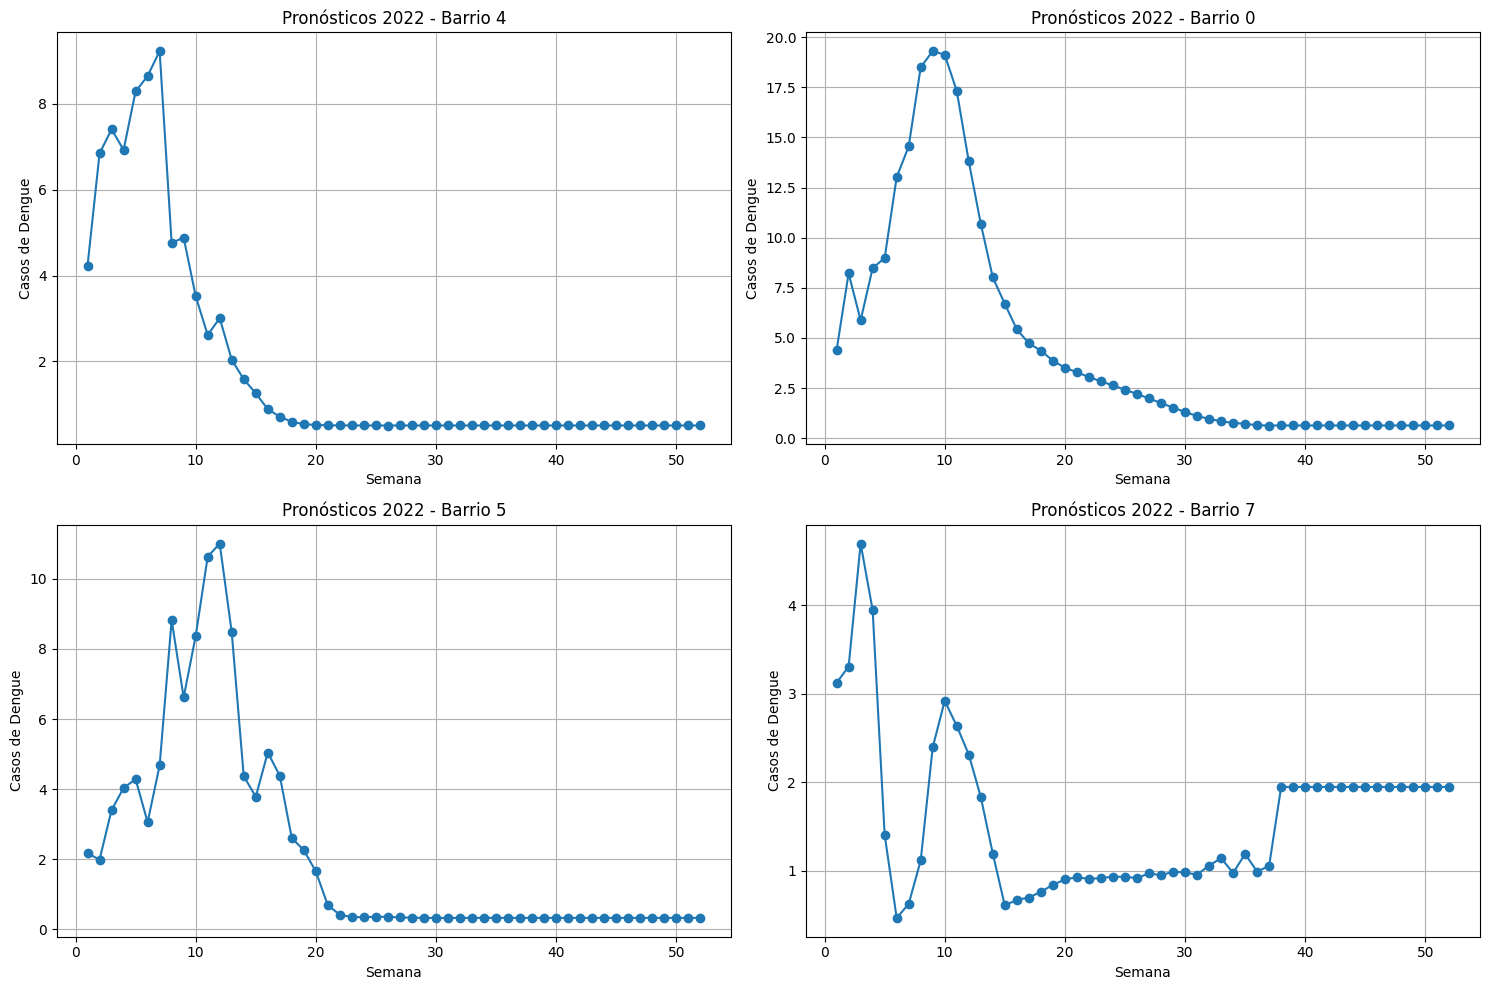


¡Proceso completado exitosamente!


In [4]:
## 9. Creación del Archivo de Salida

# Crear DataFrame con pronósticos
df_predictions = pd.DataFrame(predictions_2022)

# Formatear columna id según especificación
df_predictions['id'] = df_predictions.apply(
    lambda row: f"{int(row['id_bar'])}_{int(row['anio'])}_{int(row['semana']):02d}", 
    axis=1
)

# Seleccionar columnas finales
df_output = df_predictions[['id', 'dengue']]

# Guardar archivo CSV
fecha_actual = date.today().strftime("%Y%m%d")
nombre_archivo = f'pronosticos_RNN_2022_{fecha_actual}.csv'
df_output.to_csv(nombre_archivo, index=False)
print(f"\nArchivo 'pronosticos_2022.csv' creado exitosamente con {len(df_output)} pronósticos")

# Mostrar primeras filas del archivo
print("\nPrimeras 10 filas del archivo de salida:")
print(df_output.head(10))

# Estadísticas de los pronósticos
print(f"\nEstadísticas de pronósticos:")
print(f"Mínimo: {df_output['dengue'].min():.2f}")
print(f"Máximo: {df_output['dengue'].max():.2f}")
print(f"Media: {df_output['dengue'].mean():.2f}")
print(f"Desviación estándar: {df_output['dengue'].std():.2f}")

# Visualizar algunos pronósticos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sample_bars = np.random.choice(unique_bars, 4, replace=False)

for idx, (ax, bar) in enumerate(zip(axes.flat, sample_bars)):
    bar_preds = df_predictions[df_predictions['id_bar'] == bar]
    ax.plot(bar_preds['semana'], bar_preds['dengue'], 'o-')
    ax.set_xlabel('Semana')
    ax.set_ylabel('Casos de Dengue')
    ax.set_title(f'Pronósticos 2022 - Barrio {bar}')
    ax.grid(True)

plt.tight_layout()
plt.show()

print("\n¡Proceso completado exitosamente!")